# Feature Engineering & Model's

## Libraries

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import joblib
import itertools
import os
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Global Variables

In [2]:
# Input paths
PATH_DATAFRAME = 'full_join.xlsx'

## Global Functions

In [3]:
def polars_read_excel(file_name, sheet_name='Sheet1'):
  return pl.read_excel(source=file_name, sheet_name=sheet_name)

## Import data

In [4]:
os.chdir('../data/preprocessed')

In [5]:
df = polars_read_excel(PATH_DATAFRAME)

Could not determine dtype for column 20, falling back to string
Could not determine dtype for column 21, falling back to string
Could not determine dtype for column 22, falling back to string
Could not determine dtype for column 23, falling back to string
Could not determine dtype for column 24, falling back to string


In [6]:
df = df.with_columns([
    pl.col("CostImpact (€)").cast(pl.Float64, strict=False),
])

## Data Manipulation

In [7]:
# Filter out "Uncertain" from the original PackagingQuality
df = df.filter(pl.col("PackagingQuality") != "Uncertain")

In [8]:
df = df.with_columns([
    pl.col("DateOfReport").dt.year().alias("Year"),
    pl.col("DateOfReport").dt.month().alias("Month"),
    pl.col("DateOfReport").dt.day().alias("Day"),
    pl.col("DateOfReport").dt.weekday().alias("DayOfWeek"),
    pl.col("DateOfReport").dt.quarter().alias("Quarter")
])

df_input = (
    df 
    .sort("DateOfReport")
    .select([
         #Date features
        "DateOfReport",
        "Year",
        "Month",
        "Day",
        "DayOfWeek",
        "Quarter",
        "SupplierName",
        "GarmentType",
        "Material",
        "Weight",
        "ProposedUnitsPerCarton",
        "ProposedFoldingMethod",
        "ProposedLayout",
        "Size",
        "Collection",
        "PackagesHandled",             
        "TotalIncidents",             
        "AnomaliesDetected",          
        "BadPackagingRate (%)",        
        "OnTimeDeliveryRate (%)",      
        "AverageCostPerIncident (€)",  
        "PackagingQuality",
       
    ])
)

### Target Variable

In [9]:
# Convert Polars to Pandas
df_pd = df_input.to_pandas()

# Encode target variable
df_pd["PackagingQuality"] = df_pd["PackagingQuality"].map({"Good": 1, "Bad": 0})

# Define features and target
X = df_pd.drop(columns=["PackagingQuality","DateOfReport"])
y = df_pd["PackagingQuality"]

In [10]:
### Identify categorical columns
categorical_features = X.select_dtypes(include="object").columns.tolist()

## Model

In [11]:
def tune_lgbm_model(X_full, y_full, cat_features):
    """Performs Randomized Search CV and returns the best trained model."""
    
    # Create a copy to avoid changing the original DataFrame
    X_processed = X_full.copy()
    
    # Convert categorical columns on the full dataset before CV
    for col in cat_features:
        if col in X_processed.columns:
            X_processed[col] = X_processed[col].astype('category')

    # Define the model and parameter search space
    lgb_classifier = lgb.LGBMClassifier(objective='binary', metric='auc', boosting_type='gbdt', random_state=42)
    param_dist = {
        'n_estimators': sp_randint(400, 1200), 'learning_rate': sp_uniform(0.01, 0.1),
        'num_leaves': sp_randint(20, 50), 'max_depth': sp_randint(5, 15),
        'reg_alpha': sp_uniform(0, 1), 'reg_lambda': sp_uniform(0, 1)
    }

    # Set up the search strategy
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(
        estimator=lgb_classifier, param_distributions=param_dist, n_iter=25,
        scoring='roc_auc', cv=cv_strategy, random_state=42,n_jobs=-1
    )

    # Prepare sample weights for the fit process
    class_weights = np.where(y_full == 1, 1, 4)
    fit_params = {'sample_weight': class_weights}

    print("--- Starting Hyperparameter Tuning ---")
    random_search.fit(X_processed, y_full, **fit_params)

    print("\n--- Search Complete ---")
    print(f"Best cross-validated AUC score: {random_search.best_score_:.4f}")
    print("Best parameters found:")
    print(random_search.best_params_)
    
    return random_search.best_estimator_

# --- Run the tuning process and get our champion model ---
# We pass in the full X, y, and the list of categorical features
champion_model_lgb = tune_lgbm_model(X, y, categorical_features)

--- Starting Hyperparameter Tuning ---


/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arr

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 304203, number of negative: 74936
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 304203, number of negative: 74936
[LightGBM] [Info] Number of positive: 304202, number of negative: 74936
[LightGBM] [Info] Number of data points in t

In [12]:
# Create a Final Hold-Out Set for Evaluation 

# Split the original X and y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Convert categorical features on the new X_test
for col in categorical_features:
    if col in X_test.columns:
        X_test[col] = X_test[col].astype('category')

# Make predictions on the hold-out test set using the CHAMPION model
y_pred_lgb = champion_model_lgb.predict(X_test)
y_proba_lgb = champion_model_lgb.predict_proba(X_test)[:, 1]

### Evaluation

In [13]:
#summary report
print(classification_report(y_test, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.30      0.74      0.42     28101
           1       0.90      0.57      0.70    114076

    accuracy                           0.60    142177
   macro avg       0.60      0.65      0.56    142177
weighted avg       0.78      0.60      0.64    142177



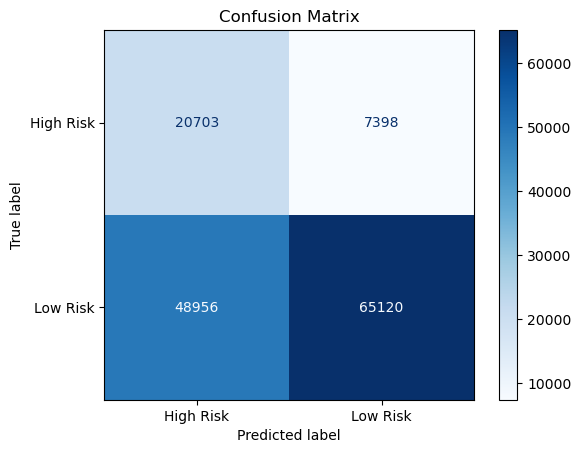

In [14]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["High Risk", "Low Risk"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

AUC: 0.7076


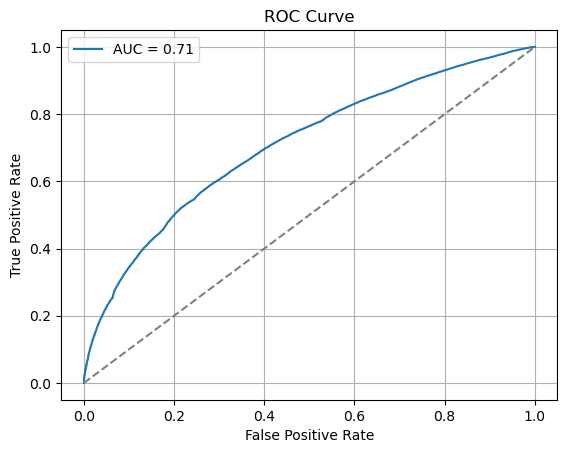

In [15]:
# AUC score
auc_score = roc_auc_score(y_test, y_proba_lgb)
print(f"AUC: {auc_score:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lgb)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Get feature names and importance values
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": champion_model_lgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
importance_df

,Feature,Importance
8,Weight,2658
2,Day,1615
9,ProposedUnitsPerCarton,1607
6,GarmentType,1356
5,SupplierName,1233
7,Material,1191
3,DayOfWeek,918
19,AverageCostPerIncident (€),801
14,PackagesHandled,750
15,TotalIncidents,749


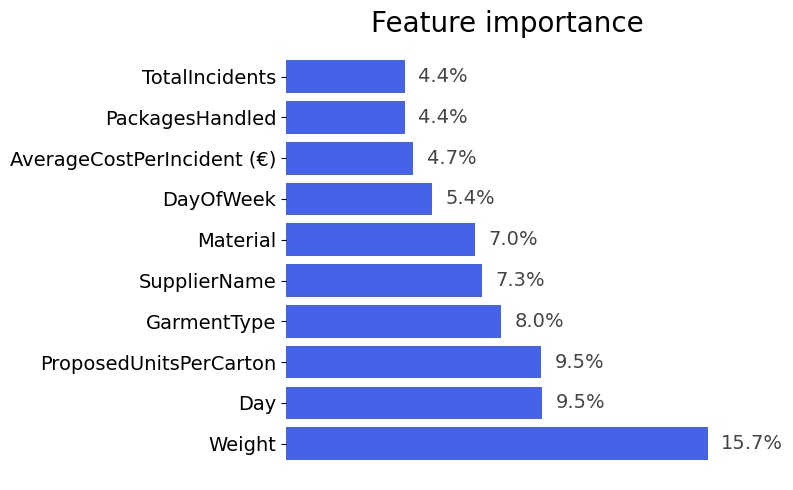

In [21]:
# Plot the top 10 feature importances as horizontal bars with percentage labels, most important at the bottom, no borders
import matplotlib.pyplot as plt

# Select top 10 features and calculate percentage
imp_sum = importance_df["Importance"].sum()
top_10 = importance_df.head(10).copy()
top_10["Percent"] = 100 * top_10["Importance"] / imp_sum

plt.figure(figsize=(8, 5))
bars = plt.barh(top_10["Feature"][::-1], top_10["Percent"][::-1], color="#4463E9", edgecolor="none")
plt.xlabel("")
plt.ylabel("")
plt.title("Feature importance", fontsize=20, fontweight="normal")
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks(fontsize=14)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)

# Add percentage labels to bars
for bar, pct in zip(bars, top_10["Percent"][::-1]):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f"{pct:.1f}%", va="center", fontsize=14, color="#444444")

plt.tight_layout()
plt.show()

In [17]:
# bring back dateofreport to the final dataframe
final_df = X_test.copy()
final_df['DateOfReport'] = df_pd.loc[X_test.index, 'DateOfReport'].values
# now we add the predictions
final_df['PredictedQuality'] = y_pred_lgb
final_df['PredictedQualityProba'] = y_proba_lgb
final_df['ActualQuality'] = y_test.values

final_df

,Year,Month,Day,DayOfWeek,Quarter,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,...,PackagesHandled,TotalIncidents,AnomaliesDetected,BadPackagingRate (%),OnTimeDeliveryRate (%),AverageCostPerIncident (€),DateOfReport,PredictedQuality,PredictedQualityProba,ActualQuality
252159,2023,10,18,3,4,SupplierA,T-Shirt,Polyester,0.12,39,...,7786.0,185.0,17.0,8.42,87.44,573.12,2023-10-18,1,0.786119,1
233515,2023,9,26,2,3,SupplierG,Shorts,Polyester,0.23,20,...,1426.0,50.0,7.0,16.55,75.58,637.83,2023-09-26,1,0.580084,1
245649,2023,10,10,2,4,SupplierH,Shirt,Polyester,0.18,39,...,865.0,57.0,11.0,38.62,61.70,563.93,2023-10-10,0,0.301614,1
101085,2023,4,27,4,2,SupplierE,Dress,Cotton,0.53,17,...,2329.0,81.0,20.0,22.33,67.45,551.40,2023-04-27,0,0.490048,1
235264,2023,9,28,4,3,SupplierA,Shirt,Polyester,0.15,36,...,8205.0,178.0,21.0,8.10,93.59,532.82,2023-09-28,1,0.810588,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325363,2024,1,11,4,1,SupplierE,Dress,Cotton,0.43,33,...,2377.0,107.0,15.0,23.01,77.06,611.66,2024-01-11,0,0.489661,1
427575,2024,5,8,3,2,SupplierD,Dress,Cotton,0.54,17,...,2859.0,126.0,19.0,32.14,68.93,516.82,2024-05-08,0,0.375215,1
18263,2023,1,22,7,1,SupplierE,Pants,Polyester,0.39,21,...,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-22,1,0.509801,1
220341,2023,9,11,1,3,SupplierG,Suit,Wool,1.11,7,...,1426.0,50.0,7.0,16.55,75.58,637.83,2023-09-11,0,0.343070,1


## Saving the model and datasets

In [22]:
#  Save the Trained LightGBM Model
if 'model_lgb' in locals():
    try:
        joblib.dump(champion_model_lgb, 'lightgbm_model.joblib')
    except Exception as e:
        print(f"ERROR saving model_lgb: {e}")

#  Save the "Pure" X_test DataFrame 
if 'X_test' in locals() and isinstance(X_test, pd.DataFrame):
    try:
        X_test.to_parquet('X_test_model_features.parquet')
    except Exception as e_parq:
        # Try CSV as a fallback if Parquet fails
        try:
            X_test.to_csv('X_test_model_features.csv', index=False)
        except Exception as e_csv:
            print(f"ERROR saving X_test (Parquet failed: {e_parq}, CSV failed: {e_csv})")


#  Savefinal_df DataFrame 
if 'final_df' in locals() and isinstance(final_df, pd.DataFrame):
    try:
        if 'DateOfReport' in final_df.columns and final_df['DateOfReport'].dtype != '<M8[ns]':
            final_df['DateOfReport'] = pd.to_datetime(final_df['DateOfReport'])
        final_df.to_parquet('final_df_for_analysis.parquet')
    except Exception as e_parq:
        # Try CSV as a fallback
        try:
            final_df.to_csv('final_df_for_analysis.csv', index=False)
        except Exception as e_csv:
            print(f"ERROR saving final_df (Parquet failed: {e_parq}, CSV failed: {e_csv})")